In [62]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import os 

%matplotlib inline

# Using Skicit-learn to split data into training and testing sets
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle

# Data Preparation

In [63]:
# Load unbalanced raw dataset
file_unbal ='/auto/home/agiamala/rf_mhw/mat_unbalanced.csv'
mat_unbal = pd.read_csv(file_unbal, header = None)
mat_unbal.columns = ['day', 'month','year','doy', 'lon', 'lat', 'Qnet','slp', 'sat', 'wind_speed','sst', 'sstRoC', 'mhw_categories']

In [64]:
mat_unbal.head()

,day,month,year,doy,lon,lat,Qnet,slp,sat,wind_speed,sst,sstRoC,mhw_categories
0,1,1,1982,1,187.625,12.625,0.731018,-568.700000,11.166991,-0.726035,0.932887,-0.209477,0
1,1,1,1982,1,190.125,12.625,-0.864615,-319.066667,11.553665,0.309211,1.372802,-0.397347,0
2,1,1,1982,1,192.625,12.625,2.299962,-81.166667,11.784982,0.700121,1.124733,-0.328405,0
3,1,1,1982,1,195.125,12.625,25.466551,154.533333,11.476991,0.710585,1.013936,-0.153395,0
4,1,1,1982,1,197.625,12.625,56.970769,390.033333,9.841682,1.007320,0.784534,-0.025855,0


In [65]:
# Select unbalanced test dataset 2017-2018
valid_data = mat_unbal[(mat_unbal["year"] == 2017) | (mat_unbal["year"] == 2018) | (mat_unbal["year"] == 2019)]

In [66]:
valid_data.head()

,day,month,year,doy,lon,lat,Qnet,slp,sat,wind_speed,sst,sstRoC,mhw_categories
5113600,1,1,2017,1,187.625,12.625,116.213735,-501.200000,13.586974,8.482409,0.416275,-0.003609,0
5113601,1,1,2017,1,190.125,12.625,129.859558,10.933333,13.753677,9.436665,0.475611,0.011909,0
5113602,1,1,2017,1,192.625,12.625,130.422035,521.333333,14.000009,9.510640,0.472171,-0.013364,0
5113603,1,1,2017,1,195.125,12.625,103.499882,1011.533333,14.821992,8.186876,0.308234,0.038589,0
5113604,1,1,2017,1,197.625,12.625,59.395534,1457.033333,15.761665,6.305441,0.287014,-0.044616,0


In [67]:
valid_data.shape

(437600, 13)

In [68]:
# Merge severe and extreme MHW categories
valid_data["mhw_categories"] = valid_data["mhw_categories"].replace(4,3)

/soft/anaconda/python3/2019.03/CentOS_7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
labels_valid = np.array(valid_data['mhw_categories'])

# Remove the labels from the features
# axis 1 refers to the columns
valid_data= valid_data.drop('mhw_categories', axis = 1)
valid_data= valid_data.drop('year', axis = 1)
valid_data= valid_data.drop('sstRoC', axis = 1)
valid_data= valid_data.drop('day', axis = 1)
valid_data= valid_data.drop('month', axis = 1)

# Saving feature names for later use
valid_data_list = list(valid_data.columns)
valid_data_list

['doy', 'lon', 'lat', 'Qnet', 'slp', 'sat', 'wind_speed', 'sst']

In [70]:
print(valid_data.shape)
print(labels_valid.shape)

(437600, 8)
(437600,)


In [71]:
# Load balanced training dataset - 7 days lag
file_name = '/auto/home/agiamala/rf_mhw/movav_7_19new.csv'
colnames = ['day', 'month','year','doy', 'lon', 'lat', 'Qnet','slp', 'sat', 'wind_speed','sst', 'sstRoC', 'mhw_categories']
allvars = pd.read_csv(file_name, names = colnames, header = None)

In [72]:
allvars.head()

,day,month,year,doy,lon,lat,Qnet,slp,sat,wind_speed,sst,sstRoC,mhw_categories
0,10,2,1982,41,187.625,12.625,-79.213716,2949.542857,10.767043,-3.728152,0.265203,0.150431,1
1,10,2,1983,41,187.625,12.625,3.192713,-295.028571,-4.065812,0.868601,-0.602023,-0.124350,0
2,10,2,1984,41,187.625,12.625,47.031827,396.257143,-14.952954,0.340358,0.379748,-0.023807,0
3,11,2,1982,42,187.625,12.625,-87.227386,2960.114286,8.415328,-4.296191,0.415634,0.041128,1
4,11,2,1983,42,187.625,12.625,22.198146,-97.742857,-4.807524,1.065265,-0.726373,-0.132473,0


In [73]:
# Merge severe and extreme MHW categories
allvars["mhw_categories"] = allvars["mhw_categories"].replace(4,3)

In [74]:
allvars = allvars.drop(allvars.index[(allvars["year"] == 2017) | (allvars["year"] == 2018) | (allvars["year"] == 2019)], axis=0) 

In [75]:
allvars.shape

(869927, 13)

In [76]:
# Labels are the values we want to predict
labels = np.array(allvars['mhw_categories'])

# Remove the labels from the features
allvars = allvars.drop('mhw_categories', axis = 1)
allvars = allvars.drop('year', axis = 1)
allvars = allvars.drop('sstRoC', axis = 1)
allvars = allvars.drop('day', axis = 1)
allvars = allvars.drop('month', axis = 1)

# Saving feature names for later use
allvars_list = list(allvars.columns)
allvars_list

['doy', 'lon', 'lat', 'Qnet', 'slp', 'sat', 'wind_speed', 'sst']

In [77]:
# Convert to numpy array
allvars = np.array(allvars)

In [78]:
allvars.shape

(869927, 8)

In [79]:
train_allvars = allvars
train_labels = labels

In [19]:
# Split the data into training and testing sets
# the random_state parameter is used for initializing the internal random number generator, 
# which will decide the splitting of data into train and test indices.
#train_allvars, test_allvars, train_labels, test_labels = train_test_split(allvars, labels, test_size = 0.0, random_state = 42)

In [80]:
print('Training allvars Shape:', train_allvars.shape)
print('Training Labels Shape:', train_labels.shape)
#print('Testing allvars Shape:', test_allvars.shape)
#print('Testing Labels Shape:', test_labels.shape)

Training allvars Shape: (869927, 8)
Training Labels Shape: (869927,)


# Randomized Cross Validation

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 9)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 3)
# Fit the random search model
rf_random.fit(train_allvars, train_labels)

In [ ]:
rf_randomCV.best_estimator_

In [ ]:
# *** Not working ***

rf_randomCV.cv_results_

In [ ]:
# Get CV results

rf_random.best_params_
df_cv_results = pd.DataFrame(rf_random.cv_results_)
df_cv_results.head()

In [ ]:
# Define evaluation means function
def evaluate(model, valid_data, labels_valid):
    predictions = model.predict(valid_data)
    predictions1 = predictions + 1 
    test_labels1 = labels_valid + 1
    errors = abs(predictions1 - test_labels1)
    mape = 100 * np.mean(errors / test_labels1)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
# Evaluate best model against base model
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(train_allvars, train_labels)
base_accuracy = evaluate(base_model, valid_data, labels_valid)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, valid_data, labels_valid)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
# Save -- too large file 
# joblib.dump(rf_randomCV, 'rf_randomCV_last.pkl')

# Random Forest
# Run RF with best model identified by CV 

In [106]:
# Assign weights - default for 0s and 1s and double weighting for 2s and 3s
weights = {0:1.0, 1:1.0, 2:2.0, 3:2.0}

# Instantiate model with N decision trees
rfc = RandomForestClassifier(n_estimators = 200, class_weight=weights, bootstrap=False , min_samples_split=2, min_samples_leaf=1, max_features="sqrt", random_state = 42, max_depth=80, oob_score=False)

# Train the model on training data
rfc.fit(train_allvars, train_labels);

In [107]:
print('Score against train set: ', rfc.score(train_allvars, train_labels))
# print('OOB Score: ', rfc.oob_score_) # only if bootstrap=True
print('Score against test set: ', rfc.score(valid_data, labels_valid))

Score against train set:  1.0
Score against test set:  0.643896252285192


In [108]:
# Make predictions for the test set
yc_pred_test = rfc.predict(valid_data)

# Add 1 to be able to do the division for MAPE 
yc_pred_test1 = yc_pred_test + 1
test_labels1 = labels_valid + 1

In [109]:
# Calculate the absolute errors
errorsc = abs(yc_pred_test1 - test_labels1)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errorsc), 2))

Mean Absolute Error: 0.4


In [110]:
# Calculate mean absolute percentage error (MAPE)
mapec = 100 * (errorsc / test_labels1)
# Calculate and display accuracy
accuracyc = 100 - np.mean(mapec)
print('Accuracy:', round(accuracyc, 2), '%.')

Accuracy: 70.02 %.


In [111]:
# AUC
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(yc_pred_test1, labels_valid, pos_label=2)
metrics.auc(false_positive_rate, true_positive_rate)

0.6490135936615259

In [112]:
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': False,
 'class_weight': {0: 1.0, 1: 1.0, 2: 2.0, 3: 2.0},
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [113]:
# View confusion matrix for test data and predictions
confusion_matrix(labels_valid, yc_pred_test)

array([[240167,  90610,   6926,    407],
       [ 14248,  35815,   6499,    514],
       [  5349,  26338,   5774,    468],
       [   610,   2793,   1069,     13]])

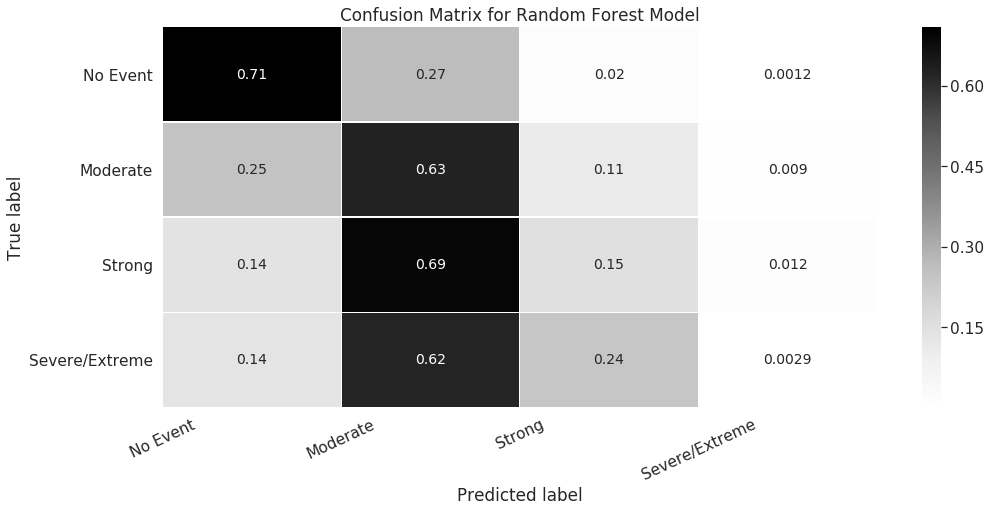

In [114]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(labels_valid, yc_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':14},
            cmap=plt.cm.Greys, linewidths=0.2)

# Add labels to the plot
class_names = ['No Event','Moderate', 'Strong', 'Severe/Extreme'] # 'Severe','Extreme']
#class_names = ['Absence', 'Presence']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [115]:
print(classification_report(labels_valid, yc_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80    338110
           1       0.23      0.63      0.34     57076
           2       0.28      0.15      0.20     37929
           3       0.01      0.00      0.00      4485

   micro avg       0.64      0.64      0.64    437600
   macro avg       0.36      0.37      0.34    437600
weighted avg       0.77      0.64      0.68    437600



In [116]:
importances = rfc.feature_importances_
print(importances)

[0.13441475 0.09692968 0.08926498 0.09381866 0.09188692 0.09339515
 0.08049325 0.31979661]


Variable: sst                  Importance: 0.32
Variable: doy                  Importance: 0.13
Variable: lon                  Importance: 0.1
Variable: lat                  Importance: 0.09
Variable: Qnet                 Importance: 0.09
Variable: slp                  Importance: 0.09
Variable: sat                  Importance: 0.09
Variable: wind_speed           Importance: 0.08


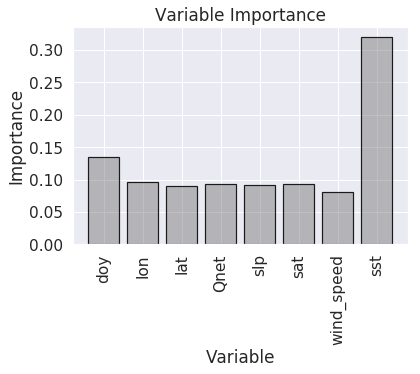

In [117]:
columns = ['doy', 'lon', 'lat', 'Qnet','slp', 'sat', 'wind_speed','sst']
feature_list = list(columns)

# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = (0.5, 0.5, 0.5, 0.5), edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation = 'vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance');

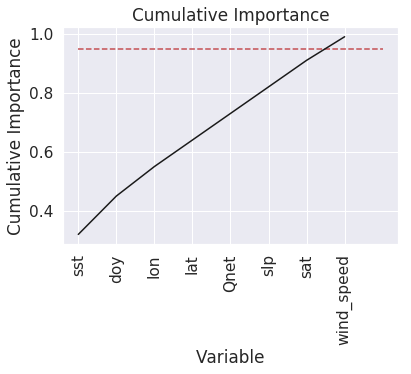

In [118]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'k-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importance');

In [119]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(labels_valid, classes=[0, 1, 2, 3])
n_classes = Y.shape[1]

print(n_classes)

4


In [120]:
lr_probs = rfc.predict_proba(valid_data)

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        lr_probs[:, i])
    average_precision[i] = average_precision_score(Y[:, i], lr_probs[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(),
    lr_probs.ravel())
average_precision["micro"] = average_precision_score(Y, lr_probs,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.76


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.76')

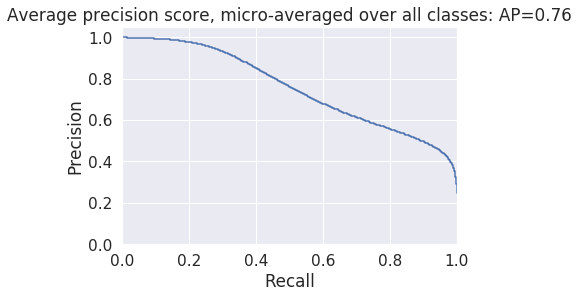

In [121]:
# Plot average precision-recall curve
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

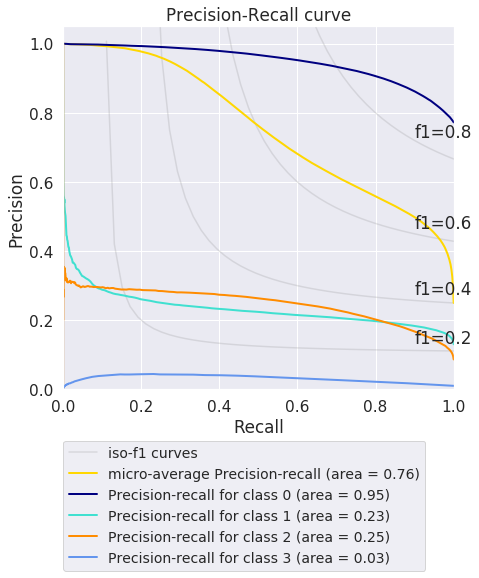

In [122]:
# Setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize = (7, 8))
f_scores = np.linspace(0.2, 0.8, num = 4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(lines, labels, loc=(0, -.5), prop=dict(size=14))


plt.show()

Adjusting Classification Threshold

In [123]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [124]:
# predict probabilities
#yhat = model.predict_proba(testX)
#lr_probs = rfc.predict_proba(valid_data)
from sklearn.metrics import f1_score
# keep probabilities for the positive outcome only
probs = lr_probs[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(labels_valid, to_labels(probs, t), average="micro") for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.881, F-Score=0.77295
